In [108]:
import random
import csv
import numpy as np
import pandas as pd
import Loader
import tensorflow as tf
import ModelFile
import Transformer
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn import model_selection
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from sklearn import svm
from sklearn.metrics import accuracy_score
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.losses import MeanSquaredError
#use for dark mode
plt.rcParams["font.family"] = "serif"
plt.style.use('default')

In [77]:
def runBasicSVM(Xtrain, Ytrain, valData):
    maxC=10
    clf=svm.SVC(
        C=maxC,                          # The regularization parameter
        kernel='rbf',                   # The kernel type used 
        degree=4,                       # Degree of polynomial function 
        gamma='scale',                  # The kernel coefficient
        coef0=0.0,                      # If kernel = 'poly'/'sigmoid'
        shrinking=True,                 # To use shrinking heuristic
        probability=False,              # Enable probability estimates
        tol=0.001,                      # Stopping crierion
        cache_size=200,                 # Size of kernel cache
        class_weight=None,              # The weight of each class
        verbose=False,                  # Enable verbose output
        max_iter=- 1,                   # Hard limit on iterations
        decision_function_shape='ovr',  # One-vs-rest or one-vs-one
        break_ties=False,               # How to handle breaking ties
        random_state=None               # Random state of the model
    )
    #Xtrain,_,valData = Transformer.normalizeData(Xtrain, compoundDataTest, compoundDataValidate, newMean=0, newStd=1)
    clf.fit(Xtrain, Ytrain)
    predictions = clf.predict(Xtrain)
    val_pred = clf.predict(valData)
    accuracy = [predictions, val_pred]
    return accuracy, clf

def get_data():
    compoundsTrain, smilesTrain, labelsTrain, compoundDataTrain, activitiesTrain = Loader.getTrain(defaultValue=0)
    compoundsTest, smilesTest, labelsTest, compoundDataTest, activitiesTest = Loader.getTest(defaultValue=0)
    compoundsValidate, smilesValidate, labelsValidate, compoundDataValidate, activitiesValidate = Loader.getValidate(defaultValue=0)

    labelsMean, trainMean = Transformer.useAverageFD(labelsTrain, compoundDataTrain)
    _, testMean = Transformer.useAverageFD(labelsTest, compoundDataTest)
    _, valMean = Transformer.useAverageFD(labelsValidate, compoundDataValidate)

    labelsMax, trainMax = Transformer.useMaxFD(labelsTrain, compoundDataTrain)
    _, testMax = Transformer.useMaxFD(labelsTest, compoundDataTest)
    _, valMax = Transformer.useMaxFD(labelsValidate, compoundDataValidate)

    #after transformations are done assign data
    dataLabels = labelsMax
    trainData = trainMax
    testData = testMax
    valData = valMax

    trainData, testData, valData = Transformer.normalizeData(trainData, testData, valData, newMean=0, newStd=1)
    
    classTrain = Transformer.toBinaryClassification(activitiesTrain)
    classVal = Transformer.toBinaryClassification(activitiesValidate)
    classTest = Transformer.toBinaryClassification(activitiesTest)
    
    return trainData, testData, valData, classTrain, classTest, classVal, dataLabels

In [6]:
def parameter_rank(top_x, epochs, avg_std_runs):
    
    trainData, testData, valData, classTrain, classTest, classVal, dataLabels = get_data()
    
    X_train, X_test, y_train, y_test = model_selection.train_test_split(trainData,classTrain,
                                       random_state=104, 
                                       test_size=0.20, 
                                       shuffle=True)
    col_idx = np.arange(0,210)
    probs = []
    for i in range(210):
        probs.append(float(50))
    probs = np.array(probs)
    eval_set = []

    for x in range(epochs):
        
        train_data_df = pd.DataFrame(X_train, columns = dataLabels)
        train_temp_df = train_data_df.copy()
        val_data_df = pd.DataFrame(X_test, columns = dataLabels)
        val_temp_df = val_data_df.copy()

        values = probs
        
        arr1 = values / values.min()
        arr1 = arr1 / arr1.sum()
        #print(arr1, arr1.sum())
        #display(values, sum(values))
        test_cols = np.random.choice(col_idx, top_x, replace=False, p = arr1)
        # using set() to perform task
        test_cols_set = set(test_cols)
        col_idx_set = set(col_idx)
        zero_cols = list(col_idx_set - test_cols_set)
        
        train_temp_df.iloc[:, zero_cols] *= 0
        val_temp_df.iloc[:, zero_cols] *= 0
        
        
        Xtrain = train_temp_df.values
        Xval = val_temp_df.values
        accuracy = runBasicSVM(Xtrain,y_train, Xval)
        curr_val_acc = accuracy_score(y_test, accuracy[1])
        
        if(x < avg_std_runs):
            eval_set.append(curr_val_acc)
        else:
            
            if curr_val_acc > np.average(eval_set) + np.std(eval_set):
                np.multiply.at(probs,test_cols,1.1)
            elif curr_val_acc < np.average(eval_set) - np.std(eval_set):
                np.multiply.at(probs,test_cols,.9)
                prev_val_acc = accuracy[1]
            else:
                prev_val_acc = accuracy[1]
                
            eval_set.pop(0)
            eval_set.append(curr_val_acc)
        
        if((((x+1)/epochs)*100)%10 == 0):
            print(((x+1)/epochs)*100, "% complete")
            #print(probs)

    top_idx = np.flip(probs.argsort()[-210:])
    #display(final_probs,final_probs.argsort()[-5:])
    res_probs_list = [probs[i] for i in top_idx]
    res_feats_list = [dataLabels[i] for i in top_idx]
    result = [res_feats_list, res_probs_list]
    #display(results, results.shape)
    rslt_df = pd.DataFrame(data = np.transpose(result), columns=['Feature','Probability Weight'])
    #sorted_rslt_df = rslt_df.sort_values(by='Probability Weight', ascending=False)
    
    train_data_df = pd.DataFrame(trainData, columns = dataLabels)
    train_temp_df = train_data_df.copy()
    val_data_df = pd.DataFrame(valData, columns = dataLabels)
    val_temp_df = val_data_df.copy()
    
    top_50_idx = probs.argsort()[-50:]
    #test_cols = np.random.choice(col_idx, top_50_idx, replace=False, p = arr1)
    # using set() to perform task
    test_cols_set = set(top_50_idx)
    col_idx_set = set(col_idx)
    zero_cols = list(col_idx_set - test_cols_set)
    
    train_temp_df.iloc[:, zero_cols] *= 0
    val_temp_df.iloc[:, zero_cols] *= 0


    Xtrain = train_temp_df.values
    Xval = val_temp_df.values
    accuracy = runBasicSVM(Xtrain,classTrain, Xval)
    in_samp_acc = accuracy_score(classTrain, accuracy[0])
    out_samp_acc = accuracy_score(classVal, accuracy[1])
    
    final_acc = [in_samp_acc, out_samp_acc]
    
    

    return rslt_df, probs, dataLabels, final_acc
#for x in rslt
results_df, final_probs, features, final_acc = parameter_rank(50,300,20)
display(results_df, final_acc)
#listToStr = ' '.join([str(elem) for i,elem in enumerate(s)])
        

10.0 % complete
20.0 % complete
30.0 % complete
40.0 % complete
50.0 % complete
60.0 % complete
70.0 % complete
80.0 % complete
90.0 % complete
100.0 % complete


,Feature,Probability Weight
0,peoe_vsa12,419.3315715011778
1,fr_aniline,324.69374507667493
2,slogp_vsa12,295.17613188788624
3,peoe_vsa9,260.3719141769857
4,fr_nh1,246.4113297336056
...,...,...
205,fr_term_acetylene,23.438939584500012
206,bcut2d_mrlow,23.204550188655
207,smr_vsa8,22.51535184350178
208,fr_arn,20.884095169789507


[0.9503128450496872, 0.9205882352941176]

In [93]:
# with pd.option_context('display.max_rows', None,'display.max_columns', None,
#     'display.precision', 3,):
#     display(results)
trainData, testData, valData, classTrain, classTest, classVal, dataLabels = get_data()

col_idx = np.arange(0,210)

train_data_df = pd.DataFrame(trainData, columns = dataLabels)
train_temp_df = train_data_df.copy()
val_data_df = pd.DataFrame(valData, columns = dataLabels)
val_temp_df = val_data_df.copy()

top_50_idx = final_probs.argsort()[-50:]
#test_cols = np.random.choice(col_idx, top_50_idx, replace=False, p = arr1)
# using set() to perform task
test_cols_set = set(top_50_idx)
col_idx_set = set(col_idx)
zero_cols = list(col_idx_set - test_cols_set)

train_temp_df.iloc[:, zero_cols] *= 0
val_temp_df.iloc[:, zero_cols] *= 0

display(train_temp_df, val_temp_df)
Xtrain = train_temp_df.values
Xval = val_temp_df.values
accuracy, clf = runBasicSVM(Xtrain,classTrain, Xval)
#display(type(clf))
in_samp_acc = accuracy_score(classTrain, accuracy[0])
out_samp_acc = accuracy_score(classVal, accuracy[1])

display(in_samp_acc,out_samp_acc)
# feature_list = list(results_df.head(50)['Feature'].values)
# listToStr = ','.join([elem for i,elem in enumerate(feature_list)])
# description = "Tim's state of the art feature reduction SVM. This model was generated in the Full Model Testing file. Features follows as comma separated list: "
# description += listToStr
# ModelFile.save(clf, "TSVM.pkl", description)
# print("In Sample ACC: ", final_acc[0])
# print("Out of Sample ACC: ", final_acc[1])
# display("Top 50 Features",results_df.head(50), "Bottom 50 Features", results_df.tail(50))
#display(description)

,docking_score_max,fusion_score_max,maxestateindex,minestateindex,maxabsestateindex,minabsestateindex,qed,molwt,heavyatommolwt,exactmolwt,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,-0.324506,-0.118902,0.0,0.0,0.0,0.0,0.0,-0.0,-0.067525,-0.0,...,-0.0,-0.369154,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,-0.0
1,-0.973915,-2.077260,-0.0,-0.0,-0.0,0.0,0.0,-0.0,-0.715770,-0.0,...,-0.0,-0.369154,-0.0,-0.0,-0.0,-0.0,0.0,0.0,-0.0,-0.0
2,0.649609,0.309322,0.0,0.0,0.0,-0.0,0.0,-0.0,-0.267394,-0.0,...,-0.0,-0.369154,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,-0.0
3,0.757843,0.234716,0.0,0.0,0.0,-0.0,-0.0,0.0,0.277596,0.0,...,-0.0,-0.369154,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,-0.0
4,-0.216271,0.200961,0.0,0.0,0.0,-0.0,0.0,-0.0,-0.521563,-0.0,...,-0.0,-0.369154,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,-0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2712,-1.515089,-1.044473,-0.0,0.0,-0.0,-0.0,0.0,-0.0,-1.824189,-0.0,...,-0.0,-0.369154,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,0.0
2713,0.541374,0.446023,0.0,-0.0,0.0,-0.0,0.0,0.0,0.550041,0.0,...,-0.0,-0.369154,0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,-0.0
2714,0.866078,0.011736,0.0,-0.0,0.0,-0.0,0.0,0.0,0.228332,0.0,...,-0.0,-0.369154,0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,-0.0
2715,-0.540975,-0.781486,0.0,-0.0,0.0,-0.0,-0.0,0.0,2.615356,0.0,...,-0.0,-0.369154,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,-0.0


,docking_score_max,fusion_score_max,maxestateindex,minestateindex,maxabsestateindex,minabsestateindex,qed,molwt,heavyatommolwt,exactmolwt,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,-1.082150,-0.383587,-0.0,0.0,-0.0,-0.0,0.0,-0.0,-1.175117,-0.0,...,-0.0,-0.369154,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,-0.0
1,0.216669,0.326262,0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.116916,-0.0,...,-0.0,-0.369154,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,-0.0
2,-0.108036,0.248714,-0.0,0.0,-0.0,0.0,0.0,-0.0,-0.521364,-0.0,...,-0.0,-0.369154,-0.0,-0.0,-0.0,-0.0,0.0,0.0,-0.0,-0.0
3,-0.108036,0.279093,-0.0,0.0,-0.0,-0.0,0.0,-0.0,-1.406374,-0.0,...,-0.0,-0.369154,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,-0.0
4,0.216669,-0.150940,0.0,0.0,0.0,-0.0,-0.0,0.0,0.241018,0.0,...,-0.0,-0.369154,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,-0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
335,0.974313,0.366547,0.0,-0.0,0.0,-0.0,-0.0,0.0,0.840825,0.0,...,-0.0,2.215875,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,-0.0
336,-0.973915,-1.190232,-0.0,0.0,-0.0,0.0,0.0,-0.0,-1.933179,-0.0,...,-0.0,-0.369154,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,-0.0
337,0.541374,0.771949,0.0,0.0,0.0,-0.0,-0.0,0.0,0.382449,0.0,...,-0.0,-0.369154,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,-0.0
338,-0.540975,0.907806,0.0,0.0,0.0,0.0,-0.0,-0.0,0.004851,-0.0,...,-0.0,-0.369154,-0.0,-0.0,-0.0,-0.0,0.0,-0.0,-0.0,-0.0


0.9915347810084653

0.9205882352941176

# Push the limits

<ipython-input-155-959c51da4cea>:55: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xlabels)


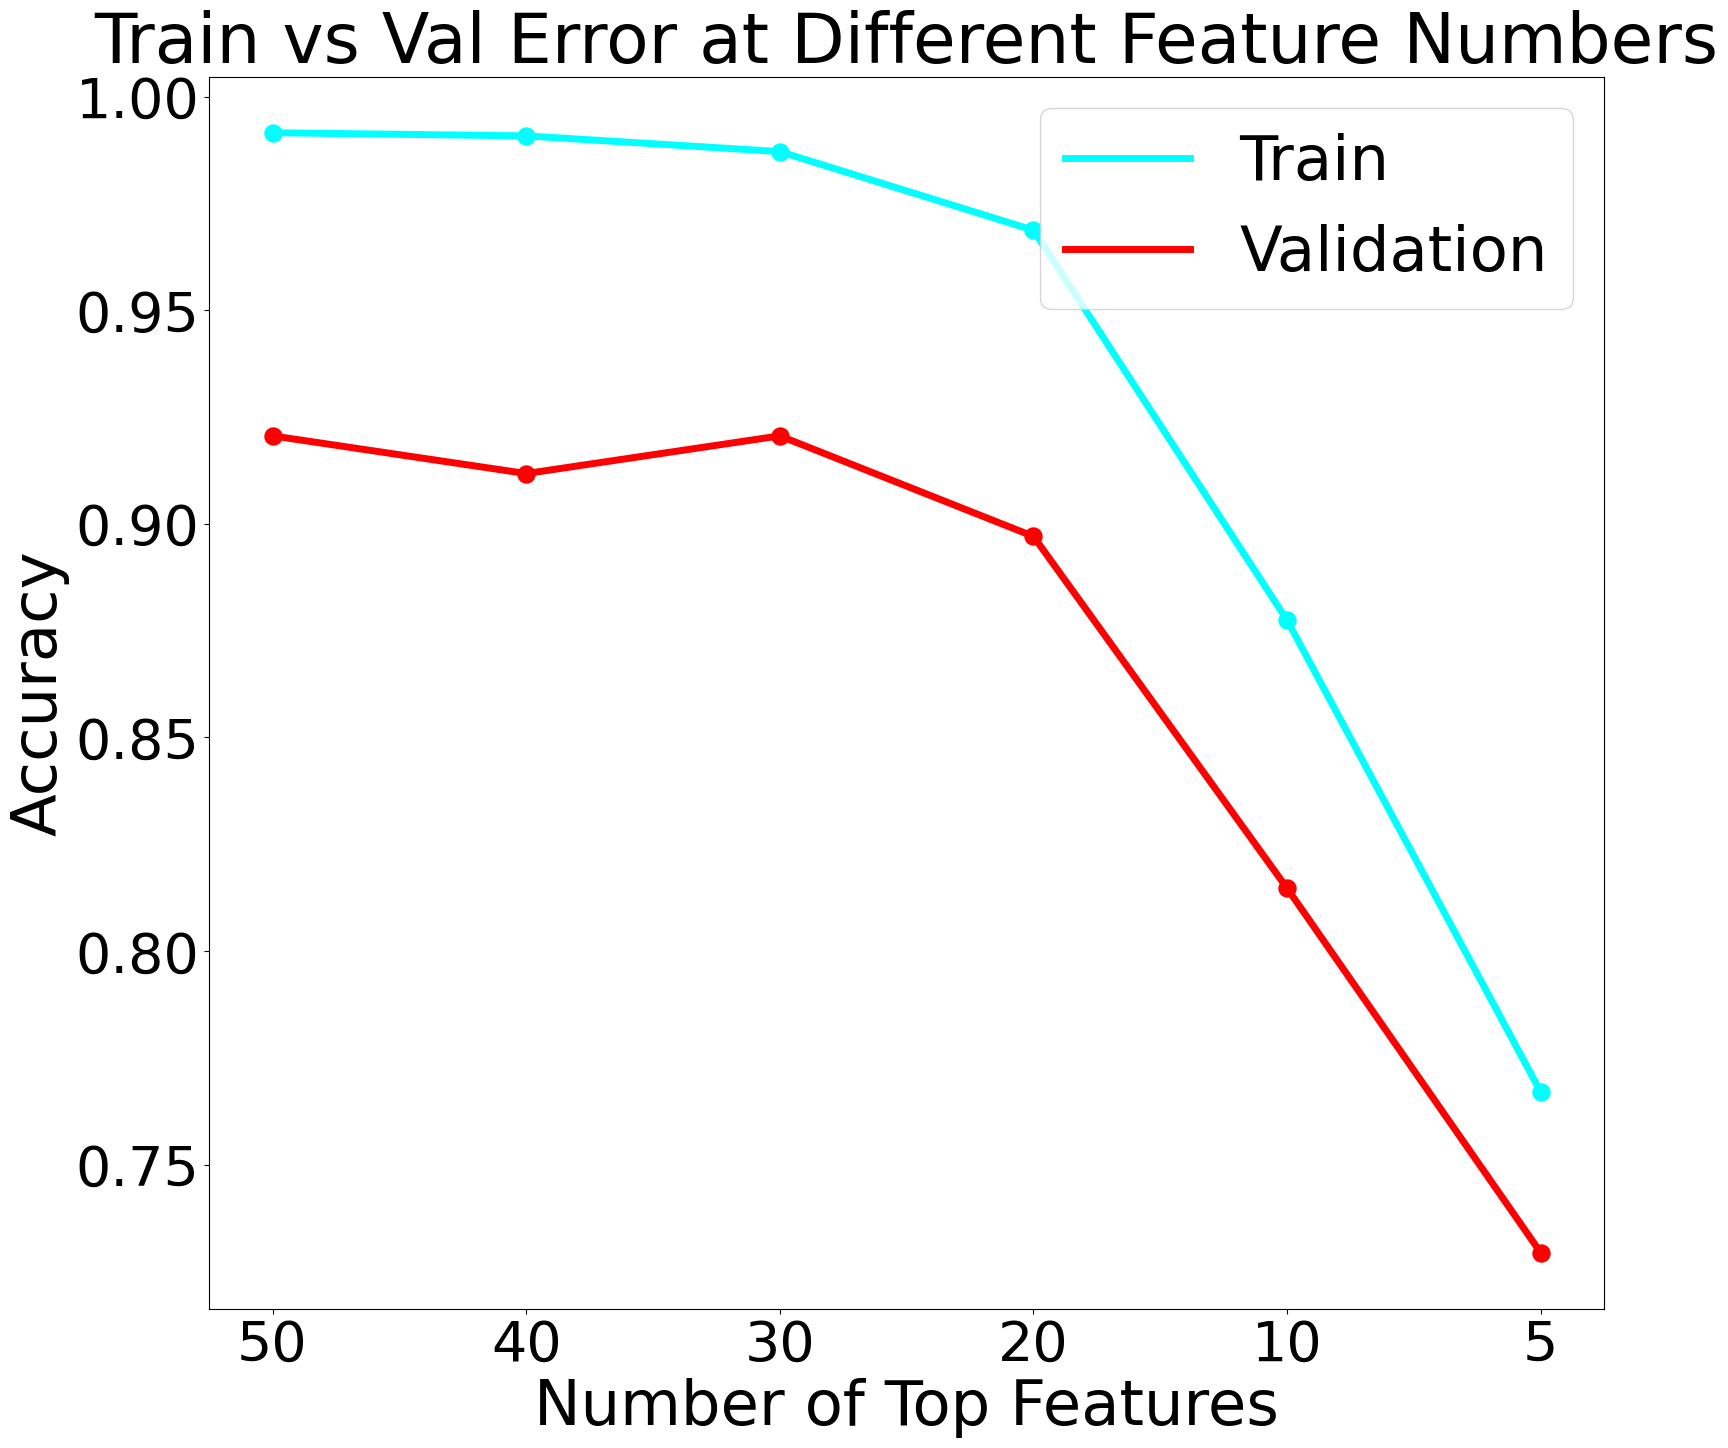

In [155]:
#for x in range(5):
trainData, testData, valData, classTrain, classTest, classVal, full_features = get_data()
fig, ax = plt.subplots(1, figsize=(18,16))
colors = ["cyan","red"]
top_50 = results_df.head(50)
top_50_features = top_50['Feature']
#print(feature, full_features)
full_feature_TF = np.isin(full_features, top_50_features)
#print(np.isin(full_features, top_50_features))
top_50_col_idx = np.where(full_feature_TF == True)[0]
col_idx = np.arange(0,210)
remove = [0 ,10, 20, 30, 40, 45]

in_samp_acc = []
out_samp_acc = []

for x in remove:
    
    temp_col_idx = top_50_col_idx.copy()
    end = 50 - x
    idx = np.arange(end, 50)
    temp_col_idx = np.delete(temp_col_idx, idx)
    
    train_data_df = pd.DataFrame(trainData, columns = full_features)
    train_temp_df = train_data_df.copy()
    val_data_df = pd.DataFrame(valData, columns = full_features)
    val_temp_df = val_data_df.copy()
    
    test_cols_set = set(temp_col_idx)
    col_idx_set = set(col_idx)
    zero_cols = list(col_idx_set - test_cols_set)
    
    train_temp_df.iloc[:, zero_cols] *= 0
    val_temp_df.iloc[:, zero_cols] *= 0
    
    Xtrain = train_temp_df.values
    Xval = val_temp_df.values
    accuracy_temp,_ = runBasicSVM(Xtrain,classTrain, Xval)
    in_samp_acc.append(accuracy_score(classTrain, accuracy_temp[0]))
    out_samp_acc.append(accuracy_score(classVal, accuracy_temp[1]))
    
    #print("Partition:", 100*dataSegments[i], "\b%, Train Err: ", avrErr[-1], "Val Err: ", avrErrVal[-1])

ticks = [0,1,2,3,4,5]
ax.scatter(ticks,in_samp_acc, color=colors[0],s=150)
ax.scatter(ticks,out_samp_acc,  color=colors[1],s=150)
ax.plot(in_samp_acc, color=colors[0],linewidth=5)
ax.plot(out_samp_acc,  color=colors[1],linewidth=5)
    
    
ax.set_title("Train vs Val Error at Different Feature Numbers", fontsize = 50)
#ax[1].set_title("Val Error at Different Data Percentages", fontsize = 24)
xlabels = ['0','50','40','30','20','10','5']

ax.set_xticklabels(xlabels)
ax.tick_params(axis='both', labelsize=40)
ax.legend(["Train","Validation"],loc = 'upper right', fontsize = 45)
ax.set_xlabel("Number of Top Features", fontsize = 45)
ax.set_ylabel("Accuracy", fontsize = 45)
plt.savefig("../Figures/TopFeaturesDrop.jpg", bbox_inches='tight')
    
    
    #print(temp_col_idx, len(temp_col_idx)

# GRAPH TOP FEATURES

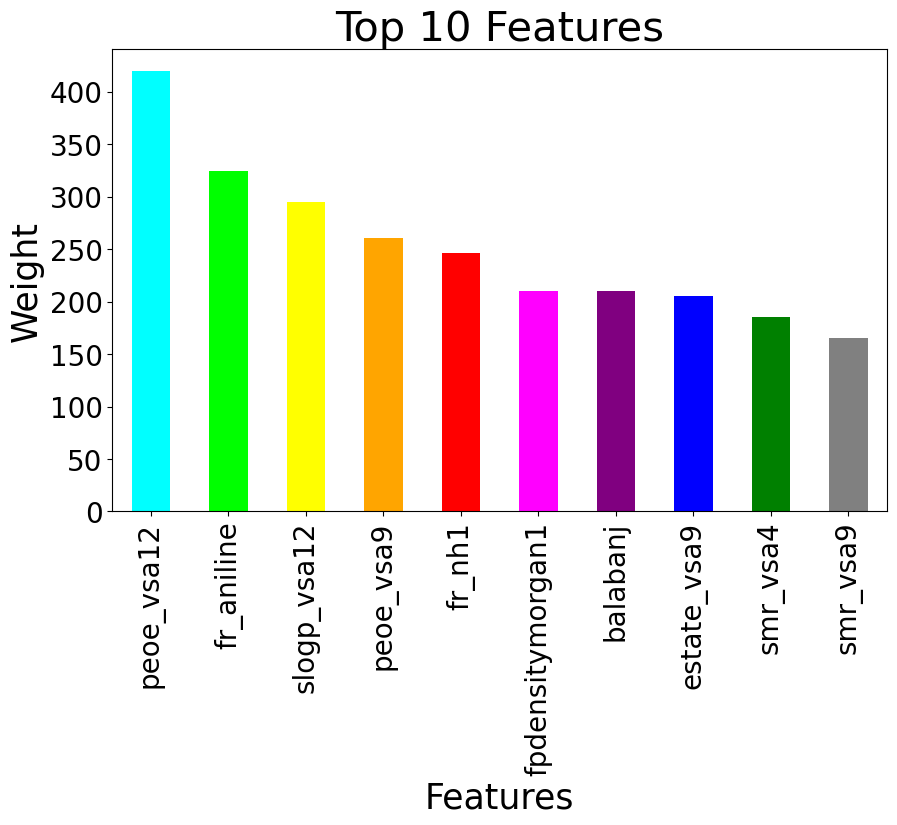

In [157]:
#fig, ax1 = plt.subplots(1, figsize=(10,12))

top_10_df = results_df.head(10)
top_10_df[['Probability Weight']] = top_10_df[['Probability Weight']].apply(pd.to_numeric)
# arr1 = top_10_df['Probability Weight'].values / top_10_df['Probability Weight'].values.min()
# arr1 = arr1 / arr1.sum()
# top_10_df[['Probability Weight']] = arr1

ax1 = top_10_df.plot(x="Feature", y="Probability Weight", kind="bar", figsize=(10, 6), 
               color=["cyan", "lime", "yellow", "orange", "red", "magenta", "purple", "blue", "green", "grey"],
              title='Top 10 Features', ylabel='Probability Weight',legend=False,fontsize=20)

ax1.set_xlabel("Features", fontsize = 25)
ax1.set_ylabel("Weight", fontsize = 25)
ax1.set_title(label='Top 10 Features', fontsize = 30)
plt.savefig("../Figures/Top10Features.jpg", bbox_inches='tight')

In [64]:
test_in_acc = []
test_out_acc = []
for x in range(10):
    results_df_100, final_probs_100, features_100, final_acc_100 = parameter_rank(50,100,20)
    test_in_acc.append(final_acc_100[0])
    test_out_acc.append(final_acc_100[1])

display(test_in_acc, np.mean(test_in_acc), test_out_acc, np.mean(test_out_acc))
feat_100 = results_df_100.head(50)
feat_300 = results_df.head(5)


#print(feat_100['Feature'].values == feat_300['Feature'].values)

10.0 % complete
20.0 % complete
30.0 % complete
40.0 % complete
50.0 % complete
60.0 % complete
70.0 % complete
80.0 % complete
90.0 % complete
100.0 % complete
10.0 % complete
20.0 % complete
30.0 % complete
40.0 % complete
50.0 % complete
60.0 % complete
70.0 % complete
80.0 % complete
90.0 % complete
100.0 % complete
10.0 % complete
20.0 % complete
30.0 % complete
40.0 % complete
50.0 % complete
60.0 % complete
70.0 % complete
80.0 % complete
90.0 % complete
100.0 % complete
10.0 % complete
20.0 % complete
30.0 % complete
40.0 % complete
50.0 % complete
60.0 % complete
70.0 % complete
80.0 % complete
90.0 % complete
100.0 % complete
10.0 % complete
20.0 % complete
30.0 % complete
40.0 % complete
50.0 % complete
60.0 % complete
70.0 % complete
80.0 % complete
90.0 % complete
100.0 % complete
10.0 % complete
20.0 % complete
30.0 % complete
40.0 % complete
50.0 % complete
60.0 % complete
70.0 % complete
80.0 % complete
90.0 % complete
100.0 % complete
10.0 % complete
20.0 % complete
30

[0.951417004048583,
 0.9447920500552079,
 0.9396393080603607,
 0.937799043062201,
 0.9462642620537357,
 0.9455281560544718,
 0.9433198380566802,
 0.9536253220463746,
 0.9422156790577844,
 0.9536253220463746]

0.9458225984541773

[0.9088235294117647,
 0.9088235294117647,
 0.8970588235294118,
 0.9088235294117647,
 0.9,
 0.9058823529411765,
 0.9176470588235294,
 0.9088235294117647,
 0.9147058823529411,
 0.9235294117647059]

0.9094117647058824

In [67]:
# display(np.isin(feat_300['Feature'].values, feat_100['Feature'].values))
# #display(feat_100, feat_300)

test = [1,2,3]
# display(final_acc_100)
x = np.arange(50,50)
np.delete(test,x)

array([1, 2, 3])